# Example of LMFit Model Custom Function

This example re-does a fit from the electron diffraction experiment to show how to use LMFit to optimize a nonlinear curve fit to an arbitrary function.

In [1]:
# Run this cell with Shift-Enter, and wait until the asterisk changes to a number, i.e., [*] becomes [1]
import numpy as np
import scipy.constants as const
import uncertainties as unc
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Import some data

Importing the graphite diffraction data that gives diffraction spot diameters as a function of accelerating voltage .

In [2]:
gr_data = pd.read_csv('graphite_data.csv')
gr_data

,AnodeV (kV),D_10 (mm),Std_10 (mm),D_11 (mm),Std_11 (mm)
0,4.432,29.501,0.356,51.106,0.403
1,4.904,28.074,0.126,49.542,0.420
2,5.382,26.879,0.421,45.922,0.153
3,5.852,25.640,0.339,44.117,0.153
4,6.323,24.963,0.392,42.318,0.593
5,6.808,24.120,0.375,40.730,0.666
6,7.295,22.974,0.195,39.790,0.201
7,7.830,22.102,0.187,38.005,0.175
8,8.314,21.913,0.208,36.887,0.468
9,8.798,21.045,0.094,36.361,0.183


## A nonlinear fit function

From theory, expect $\sin\theta$ to equal $\lambda/\sqrt{3}a$ for the {10} reflections and $\lambda/a$ for the {11} reflections, where 
$$\lambda = \frac{hc}{\sqrt{2mc^2eV}} = \left(\frac{151.4}{V}\right)^{1/2}\;\text{angstrom}$$ 
when $V$ is in volts.

So, if we plot $\sin\theta$ versus $V$ we should be able to fit the function 
$$\sin\theta(V;a) = f(V;a) = \sqrt{\frac{151.4}{V}}\left(\frac{1}{\sqrt{3}a}\right)\;\text{or}\;\sqrt{\frac{151.4}{V}}\left(\frac{1}{a}\right)$$
to the data (depending on which reflections we use) and obtain the lattice constant $a$ directly. 

### First step: convert the diameters to $\sin\theta_{hk}$

In [3]:
## Use uncertainties to make arrays so that transformed data have uncertainties

from uncertainties import unumpy
uD_10 = unumpy.uarray(gr_data['D_10 (mm)'],gr_data['Std_10 (mm)'])
uD_11 = unumpy.uarray(gr_data['D_11 (mm)'],gr_data['Std_11 (mm)'])

## Target to screen distance, in mm
L = 180.6 # mm

utan_2theta_10 = (uD_10/2)/L
usin_theta_10 = unumpy.sin(unumpy.arctan(utan_2theta_10)/2.0)
# print(['{:.2uP}'.format(angle) for angle in usin_theta_10])

utan_2theta_11 = (uD_11/2)/L
usin_theta_11 = unumpy.sin(unumpy.arctan(utan_2theta_11)/2.0)
# print(['{:.2uP}'.format(angle) for angle in usin_theta_11])


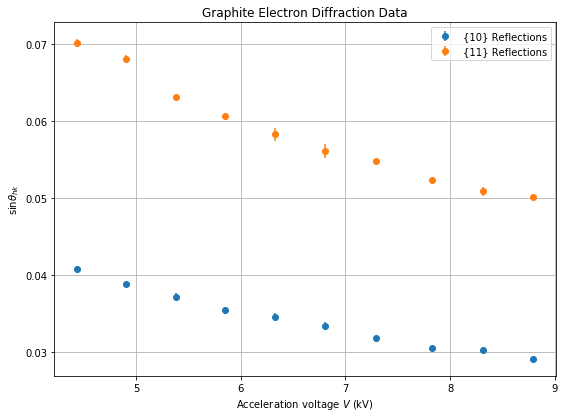

In [4]:
plt.figure(figsize=(9,6.5))
plt.grid()
plt.title('Graphite Electron Diffraction Data')
plt.ylabel(r'$\sin\theta_{hk}$')
plt.xlabel(r'Acceleration voltage $V$ (kV)')
plt.errorbar(gr_data['AnodeV (kV)'],unumpy.nominal_values(usin_theta_10),
             yerr=unumpy.std_devs(usin_theta_10),fmt='o',label='{10} Reflections')
plt.errorbar(gr_data['AnodeV (kV)'],unumpy.nominal_values(usin_theta_11),
             yerr=unumpy.std_devs(usin_theta_11),fmt='o',label='{11} Reflections')
plt.legend();

## Define the fit function

Note how the fit function is defined: the independent variable *must* be labeled `x`.  The adjustable parameters can be called what you want.  You may also pass some extra parameters to the function to stay fixed via `**kwargs` 

In [7]:
mc2 = const.value(u'electron mass energy equivalent in MeV')*1.0e6 # eV
hc = const.value(u'Planck constant in eV s')*const.speed_of_light*1.0e10 # eV-A
a_gr = 2.46 # angstrom

V_to_lambda_const = hc*hc/(2.0*mc2)

def sin_vs_V(x, lattice_const, spacing=1.0):
    sin_theta = np.sqrt(V_to_lambda_const/x)/(lattice_const*spacing)
    return sin_theta

## Set up data and weighting arrays

Separating the y-axis data into nominal values and their error bars.  Using the error bars to weight the fits.

In [8]:
V = gr_data['AnodeV (kV)']*1000 # accelerating voltage in volts

sin_data_10 = unumpy.nominal_values(usin_theta_10)
sin_err_10 = unumpy.std_devs(usin_theta_10)

sin_data_11 = unumpy.nominal_values(usin_theta_11)
sin_err_11 = unumpy.std_devs(usin_theta_11)

## Build the Models

Note that two different models are being declared, with different values of the `spacing` parameter, which is set for the different reflections.

### Note that the fit result gives the lattice constant directly.

[[Model]]
    Model(sin_vs_V, spacing='1.7320508075688772')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 10
    # variables        = 1
    chi-square         = 4.70514603
    reduced chi-square = 0.52279400
    Akaike info crit   = -5.53928284
    Bayesian info crit = -5.23669774
[[Variables]]
    lattice_const:  2.60063690 +/- 0.00463337 (0.18%) (init = 1)
[[Model]]
    Model(sin_vs_V, spacing='1.0')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 10
    # variables        = 1
    chi-square         = 56.5505914
    reduced chi-square = 6.28339905
    Akaike info crit   = 19.3255057
    Bayesian info crit = 19.6280908
[[Variables]]
    lattice_const:  2.60766773 +/- 0.00932424 (0.36%) (init = 1)


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

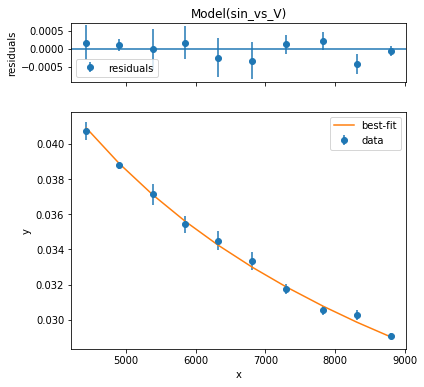

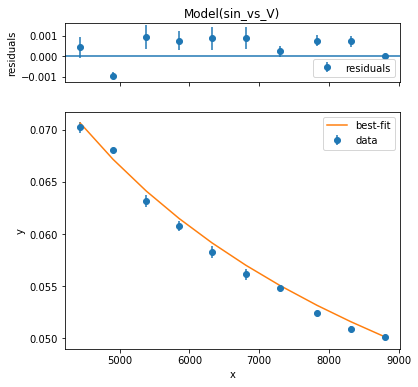

In [9]:
## Key statement to pull Model class in.
from lmfit import Model

## First argument is the function name.  The last argument is 
#  passed directly to the fitting function and is not adjusted during thefit

model_10 = Model(sin_vs_V, param_names=['lattice_const'],spacing=np.sqrt(3))
model_11 = Model(sin_vs_V, param_names=['lattice_const'],spacing=1.0)

## Fit the model for {10} reflections
result_10 = model_10.fit(sin_data_10, x=V, lattice_const=1.0, weights=1/sin_err_10)
print(result_10.fit_report())
result_10.plot()

## Fit the model for {11} reflections
result_11 = model_11.fit(sin_data_11, x=V, lattice_const=1.0, weights=1/sin_err_10)
print(result_11.fit_report())
result_11.plot()